In [1]:
import random
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%run TSP.ipynb
%matplotlib inline

In [2]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return "({},{})".format(str(self.x), str(self.y))
    
    def distancia(self, ponto):
        xd = abs(self.x - ponto.x)
        yd = abs(self.y - ponto.y)
        return np.sqrt((xd ** 2) + (yd ** 2)).astype(int)

In [3]:
class Fitness:
    def __init__(self, rota):
        self.rota = rota
        self.fitness = 0
        self.distancia = 0
    
    def percorrerRota(self):
        if self.distancia == 0:
            distanciaPercorrida = 0
            for i in range(0, len(self.rota)):
                pontoA = self.rota[i]
                pontoB = None
                if i + 1 < len(self.rota):
                    pontoB = self.rota[i + 1]
                else:
                    pontoB = self.rota[0]
                distanciaPercorrida += pontoA.distancia(pontoB)
            self.distancia = distanciaPercorrida
        return self.distancia
    
    def getFitnessRota(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.percorrerRota())
        return self.fitness

In [4]:
# Retorna novo individuo
def criarRota(pontos):
    rota = random.sample(pontos, len(pontos))
    return rota

In [5]:
# Retorna lista de individuos
def inicializaPopulacao(tamanhoPopulacao, pontos):
    populacao = []
    for i in range(0, tamanhoPopulacao):
        populacao.append(criarRota(pontos))
    return populacao

In [6]:
# Retorna Dicionário ordenado por fitness
def rankInidividuos(populacao):
    fitness = {}
    for i in range(0,len(populacao)):
        fitness[i] = Fitness(populacao[i]).getFitnessRota()
    return sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
# Seleção Proporcional(Roleta)
# Retorna lista de indices dos individuos selecionados
def selecao(rankPopulacao, numEleitos):
    selecionados = []
    
    # Cria DataFrame
    df = pd.DataFrame(np.array(rankPopulacao), columns=["Indice","Fitness"])
    
    # Realiza Soma Acumulativa
    df['Soma_Acumulativa'] = df.Fitness.cumsum()
    
    # Calcula Percentual de aptidão
    df['Percentual'] = 100 * df.Soma_Acumulativa / df.Fitness.sum()
    
    # Seleciona eleitos
    for i in range(0, numEleitos):
        selecionados.append(rankPopulacao[i][0])
        
    # Seleção Proporcional
    for i in range(0, len(rankPopulacao) - numEleitos):
        
        # Roda roleta
        pontera = 100 * random.random()
        
        # Seleciona primeiro individuo apontado
        for i in range(0, len(rankPopulacao)):
            if pontera <= df.iat[i,3]:
                selecionados.append(rankPopulacao[i][0])
                break
                
    return selecionados

In [8]:
# Retorna lista de individuos
def getProcriadores(populacao, selecionados):
    procriadores = []
    for i in range(0, len(selecionados)):
        indice = selecionados[i]
        procriadores.append(populacao[indice])
    return procriadores

In [9]:
# +/- order crossover operator (OX1 ou OX)
def procriar(pai, mae):
    filho_DNA = []
    p1_DNA = []
    p2_DNA = []
    
    # Determina genes do pai que serão passados para o filho
    geneA = int(random.random() * len(pai))
    geneB = int(random.random() * len(pai))
    
    inicioGene = min(geneA, geneB)
    fimGene = max(geneA, geneB)

    # Adicio pedaço do DNA do Pai para o filho
    for i in range(inicioGene, fimGene):
        p1_DNA.append(pai[i])
    
    # Completa restantando do DNA com o da Mãe
    p2_DNA = [gene for gene in mae if gene not in p1_DNA]

    filho_DNA = p1_DNA + p2_DNA
    return filho_DNA

In [10]:
def procriaPopulacao(procriadores, numEleitos, taxaCruzamento):
    filhos = []
    naoEleitos = len(procriadores) - numEleitos
    numProcriadores = int(naoEleitos * taxaCruzamento)
    naoProcriadores = naoEleitos - numProcriadores
    pais = random.sample(procriadores, numProcriadores)

    # Passa eleitos para próxima geração
    for i in range(0, numEleitos):
        filhos.append(procriadores[i])
    
    # Procria nova geração conforme taxa de cruzamento
    for i in range(0, numProcriadores):
        filho = procriar(pais[i], pais[numProcriadores-i-1])
        filhos.append(filho)
        
    # Preenche restante da população procriadores
    naoPais = random.sample(procriadores, naoProcriadores)
    for i in range(0, naoProcriadores):
        filhos.append(naoPais[i])
    
    return filhos

In [11]:
# Mutação por troca
def mutar(dna, taxaMutacao):
    for i in range(len(dna)):
        if(random.random() < taxaMutacao):
            j = int(random.random() * len(dna))
            
            geneA = dna[i]
            geneB = dna[j]
            
            dna[i] = geneB
            dna[j] = geneA
    return dna

In [12]:
# Retorna população mutada
def mutarPopulacao(populacao, taxaMutacao):
    populacaoMutada = []
    
    for ind in range(0, len(populacao)):
        individuoMutado = mutar(populacao[ind], taxaMutacao)
        populacaoMutada.append(individuoMutado)
    return populacaoMutada

In [13]:
def proximaGeracao(populacao, numEleitos, taxaCruzamento, taxaMutacao):
    # Ordena população conforme fitness
    rankPopulacao = rankInidividuos(populacao)
    
    # Realiza seleção dos melhor individuos
    selecionados = selecao(rankPopulacao, numEleitos)
    
    # Recupera individuos conforme indices selecionados
    procriadores = getProcriadores(populacao, selecionados)
    
    # Cria filhos a partir dos procriadores
    filhos = procriaPopulacao(procriadores, numEleitos, taxaCruzamento)
    
    # Realiza mutação nos filhos
    proximaGeracao = mutarPopulacao(filhos, taxaMutacao)
    return proximaGeracao

In [25]:
def geneticAlgorithm(pontos, tamanhoPopulacao, numEleitos, taxaCruzamento, taxaMutacao, geracoes):
    populacao = inicializaPopulacao(tamanhoPopulacao, pontos)
    progresso = []  
    
    print("Distancia Inicial: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    for i in range(0, geracoes):
        progresso.append({
            "geracao": i,
            "fitness": 1 / rankInidividuos(populacao)[0][1],
            "solucao": populacao[rankInidividuos(populacao)[0][0]]
        })
        populacao = proximaGeracao(populacao, numEleitos, taxaCruzamento, taxaMutacao)
    
    print("Distancia Final: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    indiceMelhorRota = rankInidividuos(populacao)[0][0]
    melhorRota = populacao[indiceMelhorRota]
    return {"melhorRota": melhorRota, "progresso": progresso}

In [15]:
def geneticAlgorithmPlot(pontos, tamanhoPopulacao, numEleitos, taxaCruzamento, taxaMutacao, geracoes):
    populacao = inicializaPopulacao(tamanhoPopulacao, pontos)
    progresso = []
    progresso.append(1 / rankInidividuos(populacao)[0][1])
    
    print("Distancia Inicial: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    for i in range(0, geracoes):
        populacao = proximaGeracao(populacao, numEleitos, taxaCruzamento, taxaMutacao)
        progresso.append(1 / rankInidividuos(populacao)[0][1])
    
    print("Distancia Final: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    plt.plot(progresso)
    plt.ylabel('Distancia')
    plt.xlabel('Geração')
    plt.show()

In [16]:
problem = TSP('eil51.tsp')

cityList = []

lista_ponto = list(problem.data.values())

for ponto in lista_ponto:
    cityList.append(Ponto(x=int(ponto[0]), y=int(ponto[1])))

In [17]:
#geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.00005, geracoes=200)

In [31]:
resultado = geneticAlgorithm(pontos=cityList, tamanhoPopulacao=100, numEleitos=10, taxaCruzamento=0.8, taxaMutacao=0.00005, geracoes=100)

Distancia Inicial: 1386.0
Distancia Final: 752.0


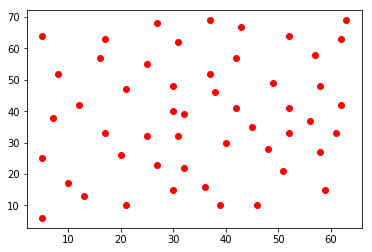

In [36]:
x = []
y = []

for p in cityList:
    x.append(p.x)
    y.append(p.y)


plt.plot(x, y, 'ro')
plt.savefig('output/foo.png')
plt.show()

In [ ]:
resultado

Geração: 0
Best Fitness: 1386.0


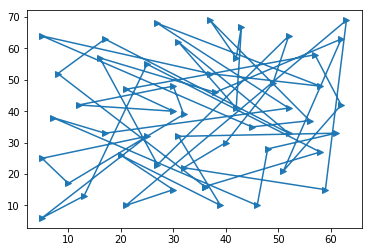

Geração: 1
Best Fitness: 1328.0


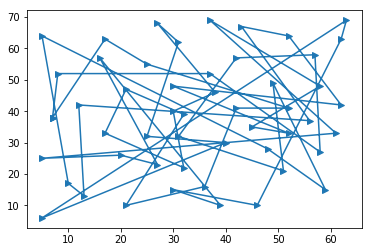

Geração: 2
Best Fitness: 1261.0


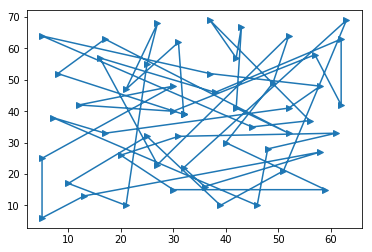

Geração: 3
Best Fitness: 1261.0


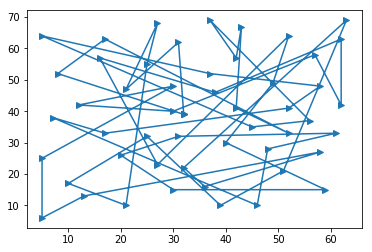

Geração: 4
Best Fitness: 1261.0


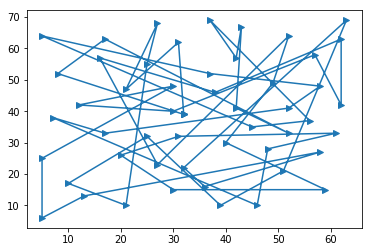

Geração: 5
Best Fitness: 1245.0


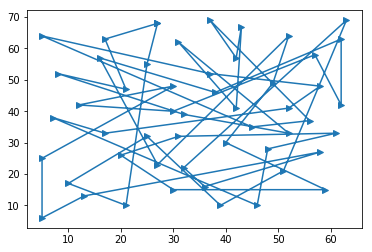

Geração: 6
Best Fitness: 1198.0


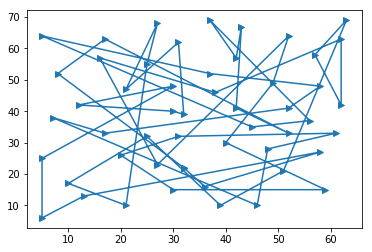

Geração: 7
Best Fitness: 1198.0


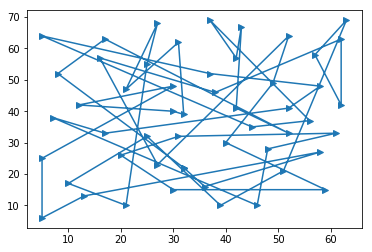

Geração: 8
Best Fitness: 1198.0


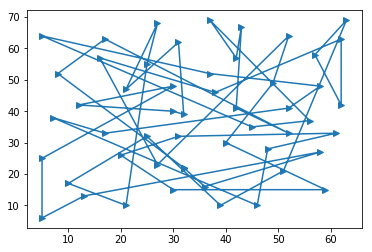

Geração: 9
Best Fitness: 1194.0


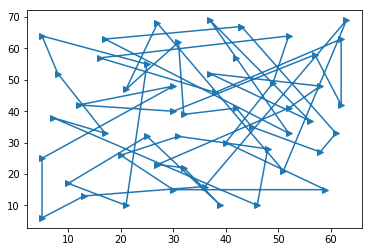

Geração: 10
Best Fitness: 1116.0


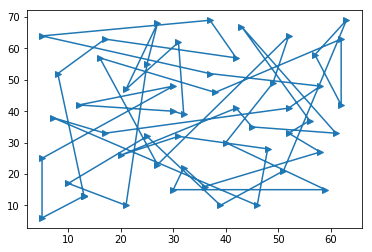

Geração: 11
Best Fitness: 1116.0


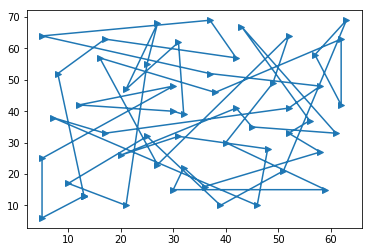

Geração: 12
Best Fitness: 1116.0


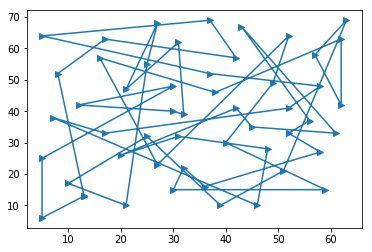

Geração: 13
Best Fitness: 1116.0


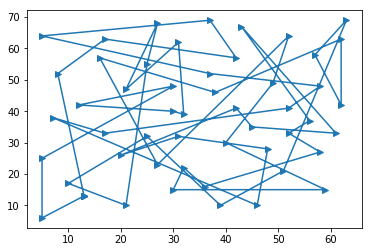

Geração: 14
Best Fitness: 1116.0


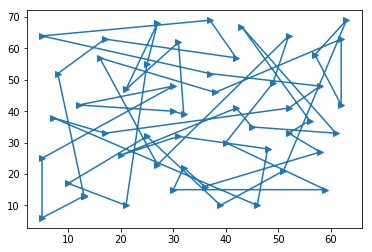

Geração: 15
Best Fitness: 1079.0


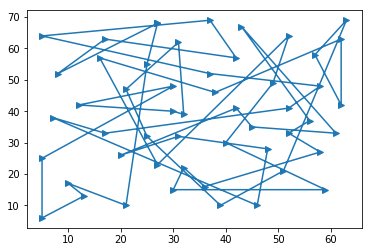

Geração: 16
Best Fitness: 1079.0


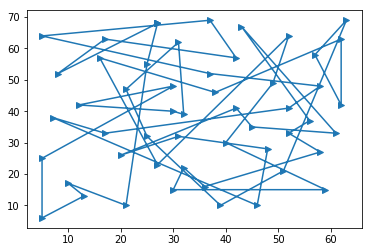

Geração: 17
Best Fitness: 1079.0


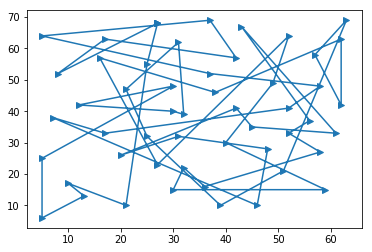

Geração: 18
Best Fitness: 1079.0


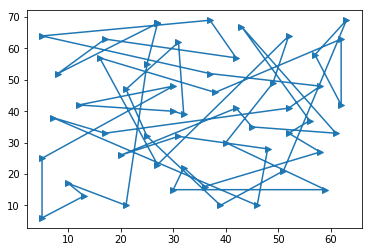

Geração: 19
Best Fitness: 1079.0


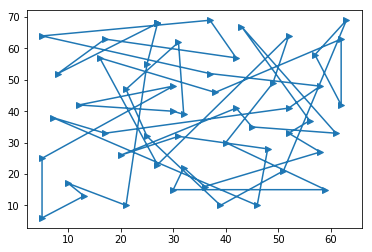

Geração: 20
Best Fitness: 1079.0


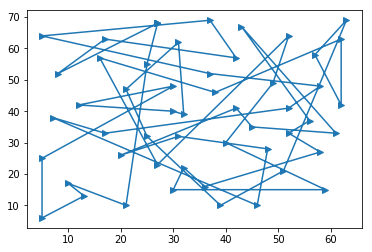

Geração: 21
Best Fitness: 1054.0


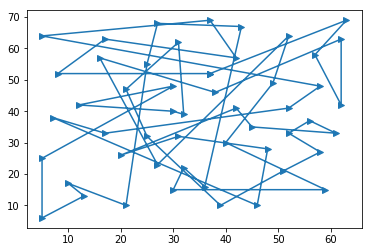

Geração: 22
Best Fitness: 1022.0


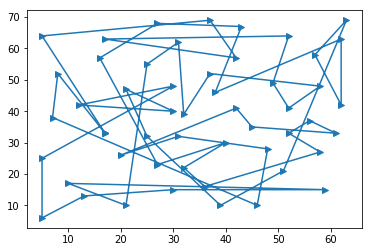

Geração: 23
Best Fitness: 1022.0


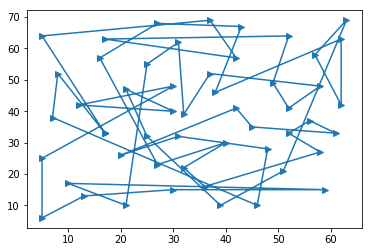

Geração: 24
Best Fitness: 1022.0


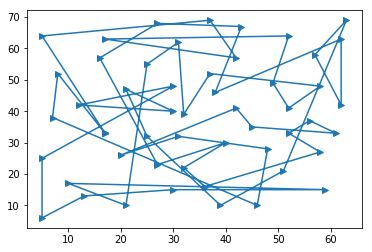

Geração: 25
Best Fitness: 1022.0


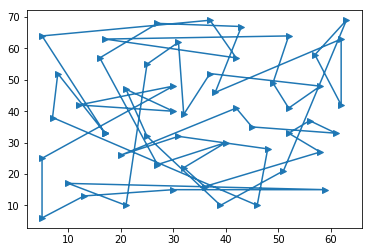

Geração: 26
Best Fitness: 1010.0


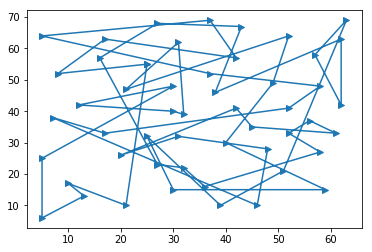

Geração: 27
Best Fitness: 971.0


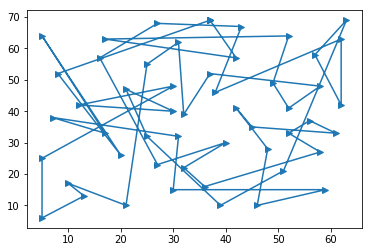

Geração: 28
Best Fitness: 971.0


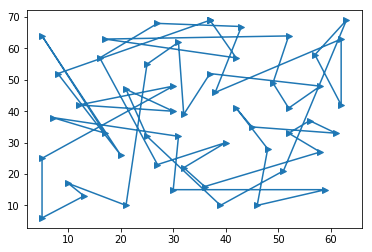

Geração: 29
Best Fitness: 971.0


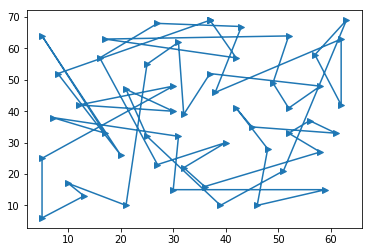

Geração: 30
Best Fitness: 916.0


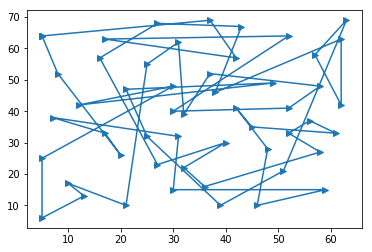

Geração: 31
Best Fitness: 916.0


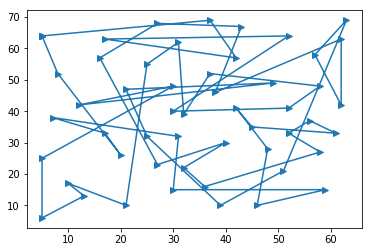

Geração: 32
Best Fitness: 916.0


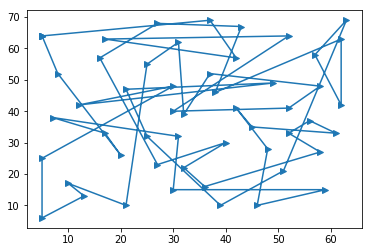

Geração: 33
Best Fitness: 916.0


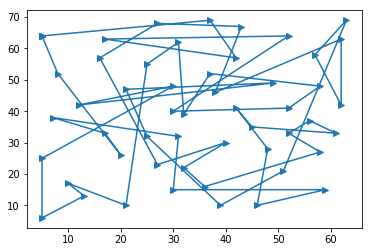

Geração: 34
Best Fitness: 916.0


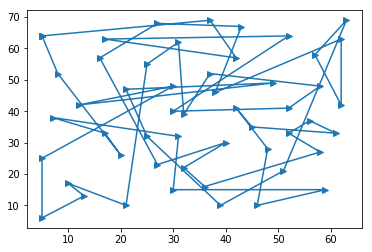

Geração: 35
Best Fitness: 916.0


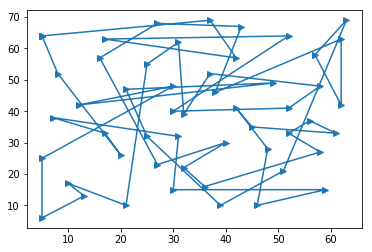

Geração: 36
Best Fitness: 916.0


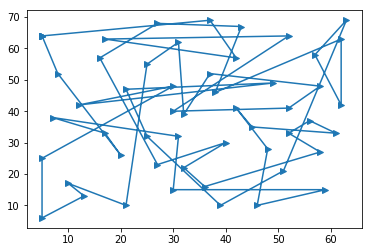

Geração: 37
Best Fitness: 909.0


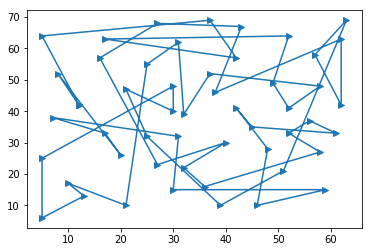

Geração: 38
Best Fitness: 909.0


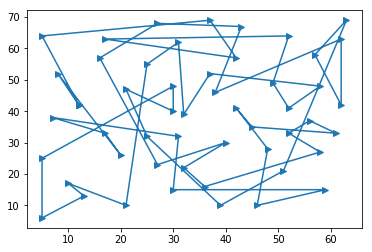

Geração: 39
Best Fitness: 909.0


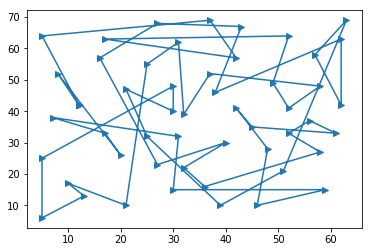

Geração: 40
Best Fitness: 909.0


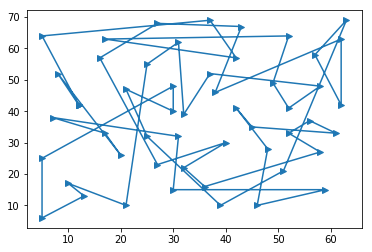

Geração: 41
Best Fitness: 909.0


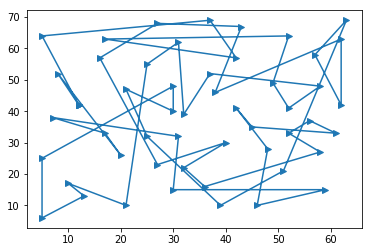

Geração: 42
Best Fitness: 909.0


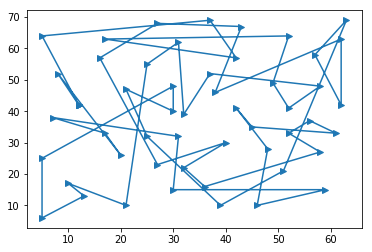

Geração: 43
Best Fitness: 909.0


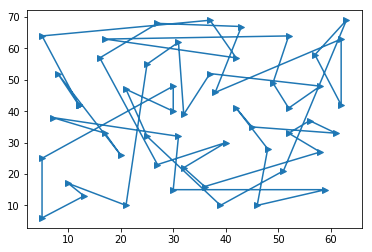

Geração: 44
Best Fitness: 909.0


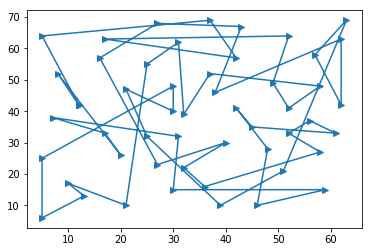

Geração: 45
Best Fitness: 909.0


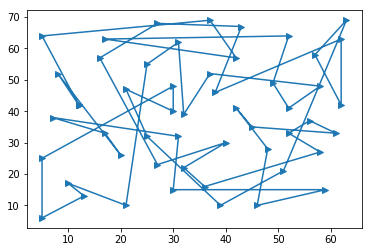

Geração: 46
Best Fitness: 866.0


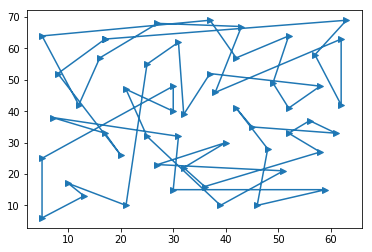

Geração: 47
Best Fitness: 866.0


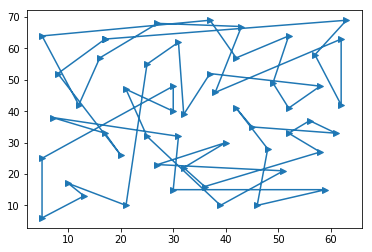

Geração: 48
Best Fitness: 866.0


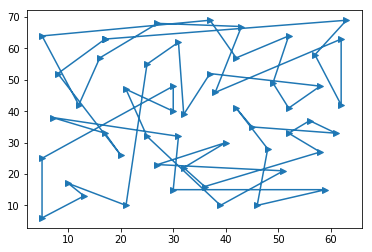

Geração: 49
Best Fitness: 853.0000000000001


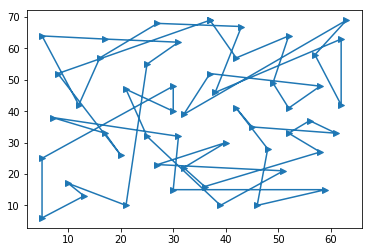

Geração: 50
Best Fitness: 850.0000000000001


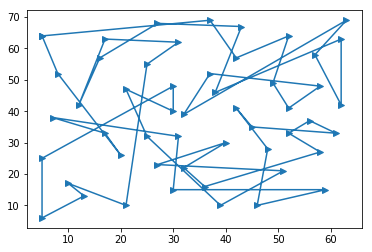

Geração: 51
Best Fitness: 848.0


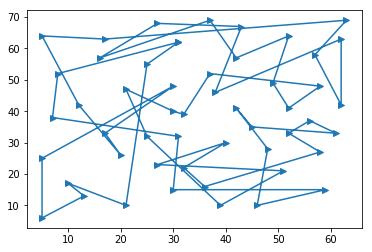

Geração: 52
Best Fitness: 848.0


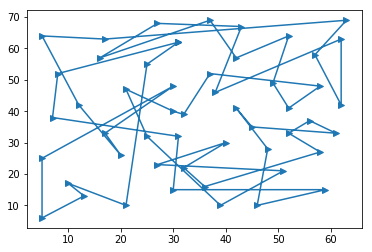

Geração: 53
Best Fitness: 836.0


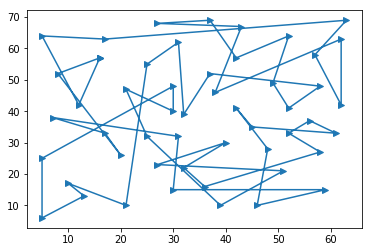

Geração: 54
Best Fitness: 836.0


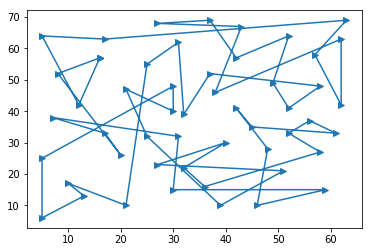

Geração: 55
Best Fitness: 836.0


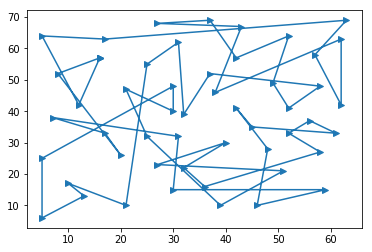

Geração: 56
Best Fitness: 829.0


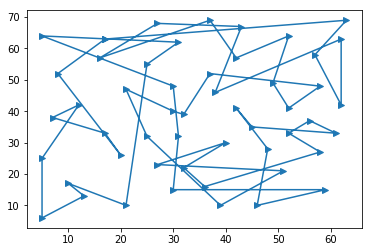

Geração: 57
Best Fitness: 822.0


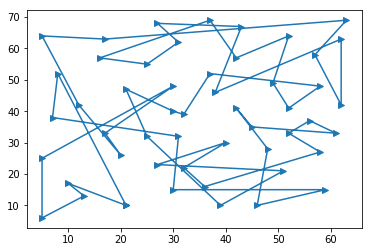

Geração: 58
Best Fitness: 822.0


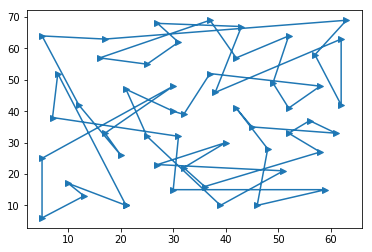

Geração: 59
Best Fitness: 789.0


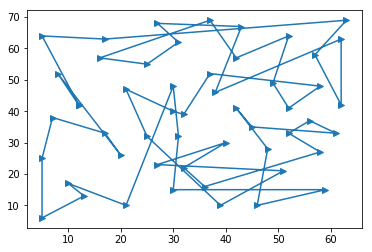

Geração: 60
Best Fitness: 789.0


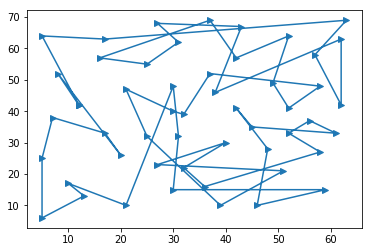

Geração: 61
Best Fitness: 789.0


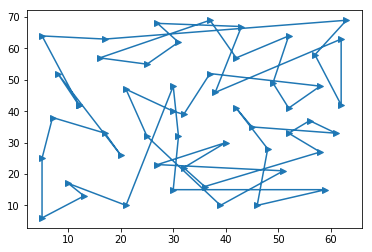

Geração: 62
Best Fitness: 789.0


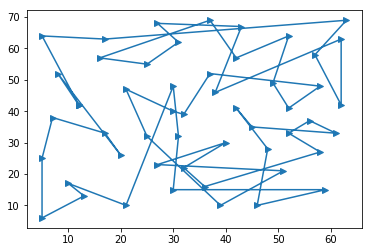

Geração: 63
Best Fitness: 789.0


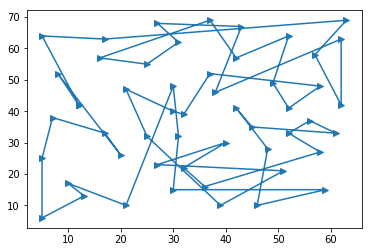

Geração: 64
Best Fitness: 789.0


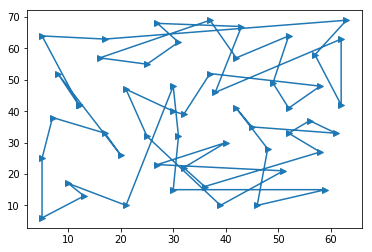

Geração: 65
Best Fitness: 783.0


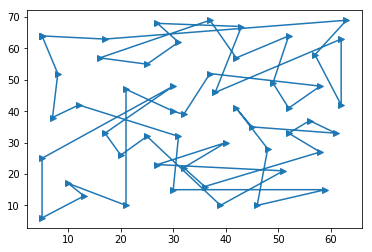

Geração: 66
Best Fitness: 783.0


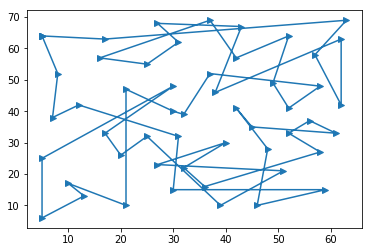

Geração: 67
Best Fitness: 783.0


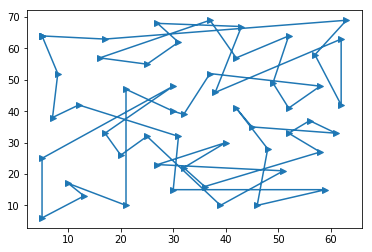

Geração: 68
Best Fitness: 783.0


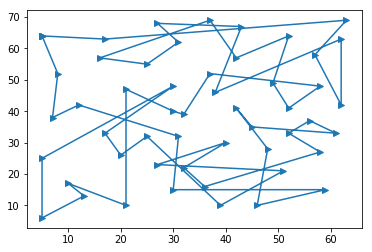

Geração: 69
Best Fitness: 783.0


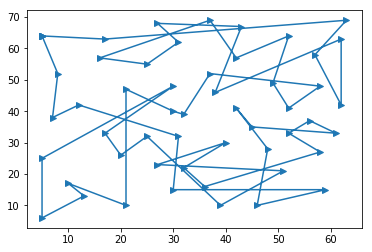

Geração: 70
Best Fitness: 783.0


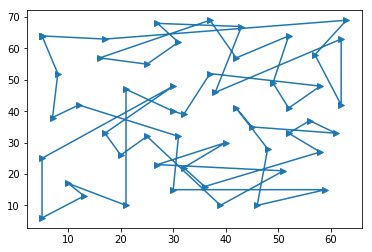

Geração: 71
Best Fitness: 783.0


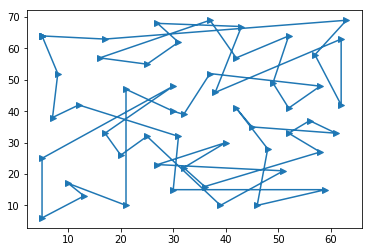

Geração: 72
Best Fitness: 781.0


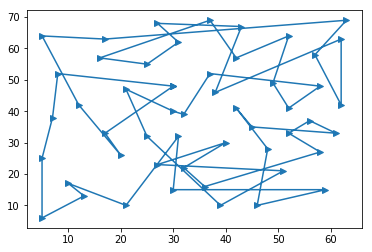

Geração: 73
Best Fitness: 781.0


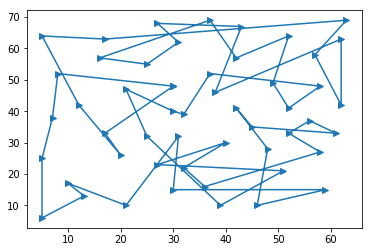

Geração: 74
Best Fitness: 777.0


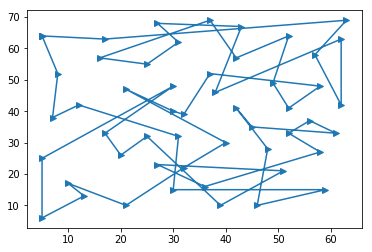

Geração: 75
Best Fitness: 777.0


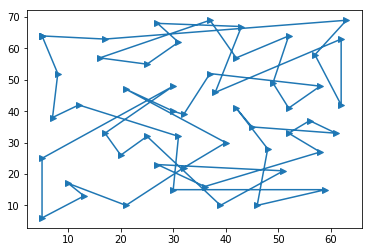

Geração: 76
Best Fitness: 777.0


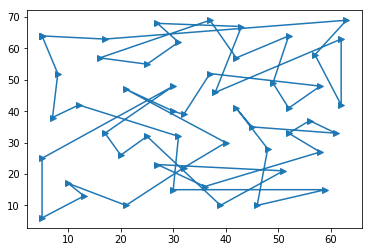

Geração: 77
Best Fitness: 777.0


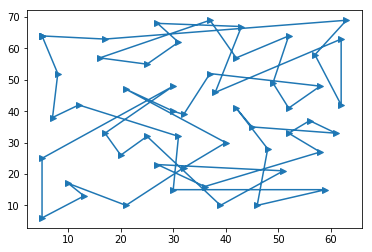

Geração: 78
Best Fitness: 777.0


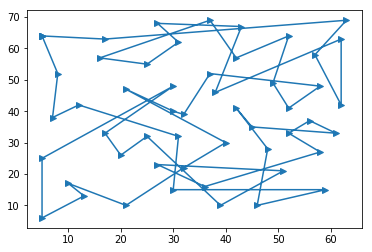

Geração: 79
Best Fitness: 766.0


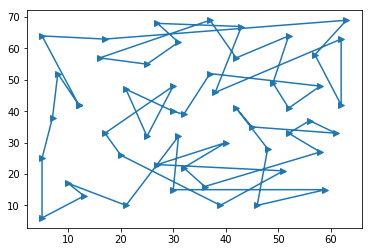

Geração: 80
Best Fitness: 766.0


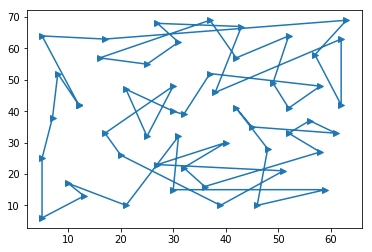

Geração: 81
Best Fitness: 766.0


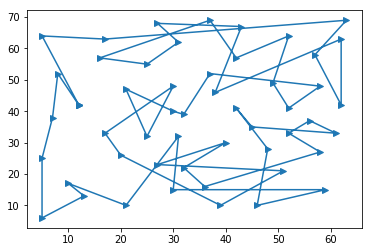

Geração: 82
Best Fitness: 766.0


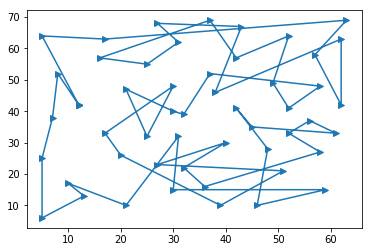

Geração: 83
Best Fitness: 765.0


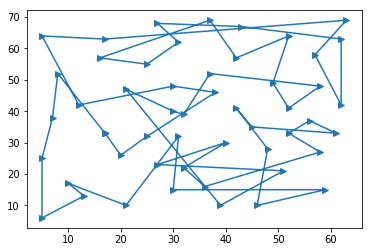

Geração: 84
Best Fitness: 765.0


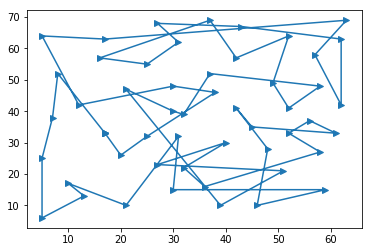

Geração: 85
Best Fitness: 765.0


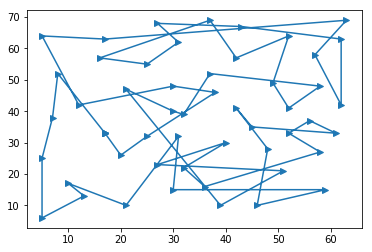

Geração: 86
Best Fitness: 765.0


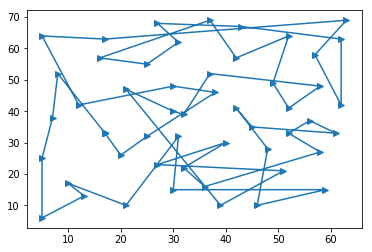

Geração: 87
Best Fitness: 765.0


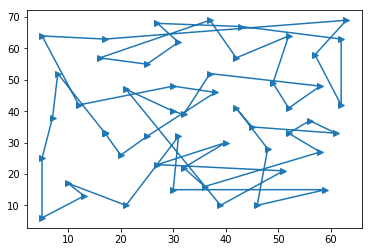

Geração: 88
Best Fitness: 765.0


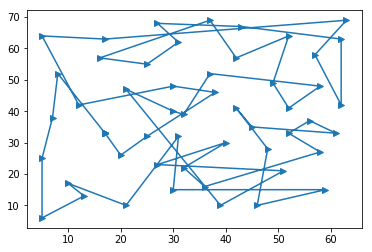

Geração: 89
Best Fitness: 765.0


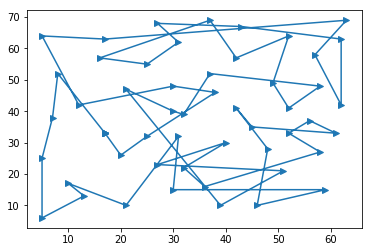

Geração: 90
Best Fitness: 754.0


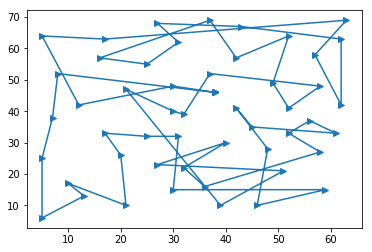

Geração: 91
Best Fitness: 754.0


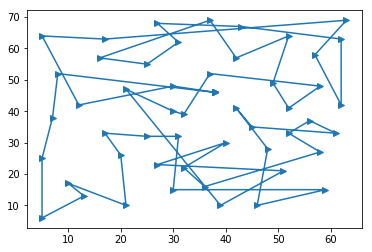

Geração: 92
Best Fitness: 754.0


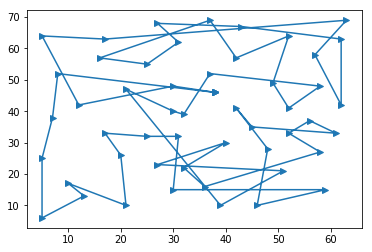

Geração: 93
Best Fitness: 754.0


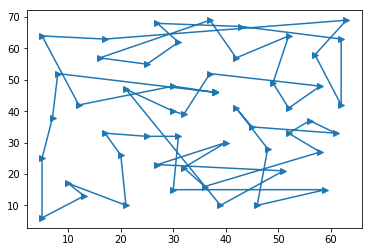

Geração: 94
Best Fitness: 754.0


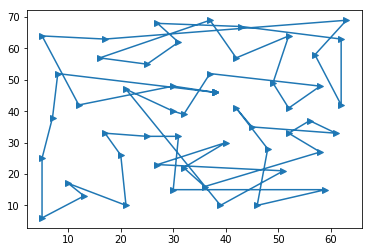

Geração: 95
Best Fitness: 754.0


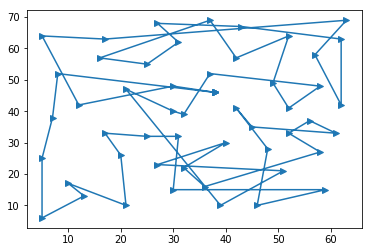

Geração: 96
Best Fitness: 754.0


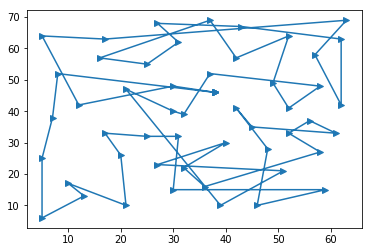

Geração: 97
Best Fitness: 754.0


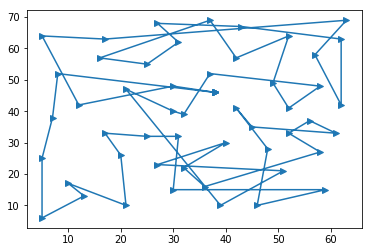

Geração: 98
Best Fitness: 752.0


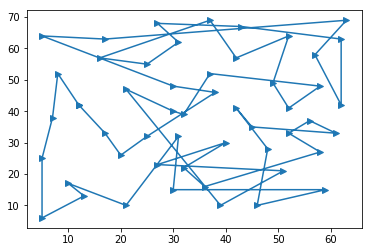

Geração: 99
Best Fitness: 752.0


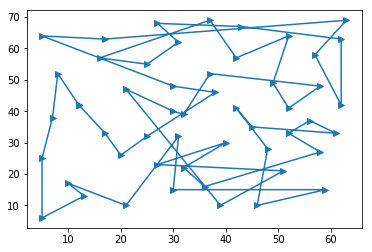

In [37]:
for g in resultado["progresso"]:
    print("Geração: {}".format(g["geracao"]))
    print("Best Fitness: {}".format(g["fitness"]))
    
    s = g["solucao"]
    s.append(s[0])
    
    x = []
    y = []

    for p in s:
        x.append(p.x)
        y.append(p.y)

    
    plt.plot(x, y, '->')
    plt.savefig('output/{}.png'.format(g["geracao"]))
    plt.show()




#plt.plot(x, y, 'ro')
#plt.plot(x, y, '->')

#plt.show()

#plt.plot(x, y, '->')

#plt.show()

In [22]:
#cityList = []

#for i in range(0,25):
#    cityList.append(Ponto(x=int(random.random() * 200), y=int(random.random() * 200)))